# Molecular VAE

In [1]:
# imports
import pandas as pd
import numpy as np
import re
import torch
import torch.utils.data as tud
from torch import nn
from torch.nn import functional as F

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# chemistry
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True  #set this to False if you want PNGs instead of SVGs

RDKit WARNING: [10:37:38] Enabling RDKit 2019.09.1 jupyter extensions


## Load data

In [2]:
chembl = pd.read_csv("data/cleaned_dataset.csv")
chembl.head()

,ChEMBL ID,Smiles,AlogP,QED Weighted
0,CHEMBL2333117,CC(C)Nc1c(C(N)=O)nnc2ccc(-c3cnn(C)c3)cc12,1.95,0.77
1,CHEMBL1189585,CC1C(=O)NC2=Nc3sc4c(c3CN21)CCCC4,1.95,0.78
2,CHEMBL4089494,CNC(=O)c1ccc(NC(=O)Nc2ccc(-c3nc(N4CCOCC4)c4ncc...,3.53,0.40
3,CHEMBL1189590,CN(C)c1nccc2c1nnn2Cc1ccccc1F,2.08,0.73
4,CHEMBL3927722,Cc1noc(C)c1Cn1cc(NC(=O)Cc2ccco2)cn1,2.31,0.78


## Data preparation & encoding

Steps to prepare VAE input data:
1. SMILES tokenization (add start/end tokens)
2. SMILES token encoding (convert to integer indecies) -> build a vocabulary
3. Set up a SMILES dataset class (for feeding batches of data to the VAE)

### Utility classes/functions

In [57]:
class SMILESTokenizer(object):
    
    def __init__(self, pattern="(Br|Cl)"):
        self.pattern = re.compile(pattern)

    def getPattern(self):
        """Returns compiled regex pattern for multi-character tokens"""
        return self.pattern

    def tokenize(self, smi:str) -> list:
        """Tokenizes an input SMILES string"""
        if not self.pattern:
            return list(smi)
        # split input SMILES string using the supplied regex pattern    
        splitted = self.pattern.split(smi)
        tokens = []
        for i, s in enumerate(splitted):
            # make sure Br and Cl are treated as a single token
            if i % 2 == 0:
                tokens.extend(list(s))
            else:
                tokens.append(s)
        return tokens

    def untokenize(self, tokens:list) -> str:
        """Concatenates a list of tokens into a SMILES string"""
        return "".join(tokens)
    

class SMILESVocabulary(object):
    """Keeps track of string tokens and their associated integer indecies"""
    
    def __init__(self):
        self._tokens_idxs = {} # vocabulary
        self._current_idx = 0 # currently available index
        # add start, end, padding tokens
        self.sos = "<sos>"
        self.eos = "<eos>"
        self.pad = "<pad>"
        self.update([self.pad, self.sos, self.eos])
            
    def __getitem__(self, token_or_idx):
        return self._tokens_idxs[token_or_idx]
    
    def __len__(self):
        return len(self._tokens_idxs) // 2
    
    def getStartIdx(self):
        return self._tokens_idxs[self.sos]
    
    def getEndIdx(self):
        return self._tokens_idxs[self.eos]
    
    def getPadIdx(self):
        return self._tokens_idxs[self.pad]
    
    def add(self, token:str):
        assert type(token) == str, "Token must be of type string."
        if token not in self._tokens_idxs:
            self._tokens_idxs[token] = self._current_idx
            self._tokens_idxs[self._current_idx] = token
            # update first available index
            self._current_idx += 1
            
    def tokens(self):
        """Returns a list of all tokens in the vocabulary"""
        return [t for t in self._tokens_idxs if type(t) == str]

    def update(self, tokens:list):
        """Updates the vocabulary with an iterable of tokens"""
        for t in tokens:
            self.add(t)
        
    def encode(self, tokens:list) -> list:
        """
        Encodes a list of tokens as a list of integer indecies.
        Attaches sos and eos idecies at the beginning and end of
        the encoded sequence.
        """
        smi_seq = [self._tokens_idxs[t] for t in tokens]
        return [self.getStartIdx()] + smi_seq + [self.getEndIdx()]
    
    def decode(self, indices:list) -> list:
        """
        Decodes a list of interger indices as a list of tokens.
        Ignores 1st sos idx and truncates the sequence if it encounters
        a special idx further down. 
        """
        tokens = []
        spec_idxs = [self.getStartIdx(), self.getEndIdx(), self.getPadIdx()]
        for i, idx in enumerate(indices):
            if (idx == self.getStartIdx()) & (i == 0):
                continue
            if (idx in spec_idxs) & (i > 0):
                break
            else:
                tokens.append(self._tokens_idxs[idx])
        return tokens

    def build(self, smiles:list, tokenizer:SMILESTokenizer) -> None:
        """
        Builds a vocabulary using a list of SMILES and
        an instance of a Tokenizer object. Any existing
        vocabulary is reset.
        -------------------------------
        smiles - iterable of SMILES strings
        tokenizer - instantiated SMILESTokenizer object
        
        returns None
        """
        # reset current vocabulary
        self.__init__()
        # build new vocabulary
        tokens = set()
        for smi in smiles:
            tokens.update(tokenizer.tokenize(smi))
        self.update(sorted(tokens))
        
    def save(self, path):
        """Saves the vocabulary to disk"""
        voc = [[k, v] for k, v in self._tokens_idxs.items() if isinstance(k, str)]
        voc_df = pd.DataFrame(voc, columns=["token", "index"])
        voc_df.to_csv(path, index=False)
    
    def load(self, path):
        """Loads a stored vocabulary from disk"""
        # reset current vocabulary
        self.__init__()
        # build vocabulary from csv file
        voc_df = pd.read_csv(path)
        for _, row in voc_df.iterrows():
            token = row["token"]
            idx = row["index"]
            self._tokens_idxs[token] = idx
            self._tokens_idxs[idx] = token
            self._current_idx = max(self._current_idx, idx)
        # update the currently available index
        self._current_idx += 1


class SMILESDataset(tud.Dataset):
    """Custom dataset class for producing batches of SMILES"""
    
    def __init__(self, smiles, vocabulary:SMILESVocabulary, tokenizer:SMILESTokenizer):
        """
        Creates a dataset from an iterable of SMILES, a built vocabulary of tokens
        and a SMILES tokenizer.
        """
        super().__init__()
        self._smiles = list(smiles)
        self._vocabulary = vocabulary
        self._tokenizer = tokenizer
        
    def __getitem__(self, idx:int):
        """Returns a molecule at index idx as an encoded SMILES tensor"""
        smi = self._smiles[idx]
        smi_enc = self._vocabulary.encode(self._tokenizer.tokenize(smi))
        return torch.LongTensor(smi_enc)
    
    def __len__(self):
        return len(self._smiles)
    
    def getCollateFn(self):
        """
        Generates the collate function that will pad all
        sequences in a batch to the same max. length using the pad idx
        defined in the vocabulary.
        """
        def collate_fn(enc_tensors:list):
            """
            Pads encoded SMILES tensors to the same max. length using the pad idx.
            The output tensor has shape: (batch_sz, max. length)
            """
            batch_sz = len(enc_tensors)
            max_len = max([t.size(0) for t in enc_tensors])
            padded = torch.full((batch_sz, max_len), self._vocabulary.getPadIdx(), dtype=torch.long)
            # pad encoded batch of SMILES
            for i, t in enumerate(enc_tensors):
                padded[i, :t.size(0)] = t
            return padded
        
        return collate_fn


def countTokens(smiles:list, tokenizer:SMILESTokenizer, tokenCol:str="token", cntCol:str="cnt") -> pd.DataFrame:
    """Computes the token frequency in the smiles iterable"""
    token_cnts = {}
    for smi in smiles:
        # tokenize SMILES string
        tokenized = tokenizer.tokenize(smi)
        # count tokens
        for t in tokenized:
            try:
                token_cnts[t] += 1
            except KeyError:
                token_cnts[t] = 1
    return pd.DataFrame([[t, c] for t, c in token_cnts.items()], columns=[tokenCol, cntCol])


### Build a vocabulary

In [60]:
tokenizer = SMILESTokenizer()
vocabulary = SMILESVocabulary()

In [9]:
# vocabulary.build(chembl["Smiles"], tokenizer)

In [10]:
# # save vocabulary
# vocabulary.save("data/vocabulary.csv")

In [61]:
# load vocabulary
vocabulary.load("data/vocabulary.csv")

### Analyze token frequencies

In [12]:
token_cnts = countTokens(chembl["Smiles"], tokenizer)
token_cnts

,token,cnt
0,C,12896279
1,(,7025189
2,),7025189
3,N,2682981
4,c,18431345
5,1,4604265
6,=,2904352
7,O,4388805
8,n,2124346
9,2,3590237


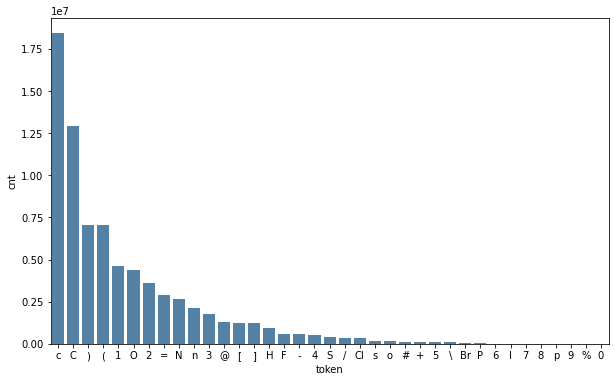

In [13]:
# plot token distribution
fig, ax = plt.subplots(figsize=(10, 6))
_ = sns.barplot(data=token_cnts.sort_values("cnt", ascending=False), x="token", y="cnt", color="steelblue", ax=ax)

### Build a dataset

In [44]:
dataset = SMILESDataset(chembl["Smiles"], vocabulary, tokenizer)

In [45]:
# test producing batches with dataloader
dataloader = tud.DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=dataset.getCollateFn())

In [46]:
dloader_iter = iter(dataloader)

In [47]:
batch = next(dloader_iter)
batch

tensor([[ 1, 23, 23,  ...,  0,  0,  0],
        [ 1, 23, 23,  ...,  0,  0,  0],
        [ 1, 29, 20,  ...,  0,  0,  0],
        ...,
        [ 1, 23, 23,  ...,  0,  0,  0],
        [ 1, 23, 29,  ...,  0,  0,  0],
        [ 1, 23, 29,  ...,  0,  0,  0]])

In [48]:
batch.size()

torch.Size([16, 103])

## NN modules

The variational autoencoder consists of the following components:
1. SMILES encoder: maps input sequences to a latent vector z
2. Decoder: decodes a latent vector z into a sequence

In [49]:
class MolecularVAE(nn.Module):
    """
    Encodes a sequence as a probability distribution over a latent space - z
    and samples from this probability distribution.
    """
    
    def __init__(self, vocab_sz:int, embedding_dim:int, hidden_dim:int, latent_dim:int, sos_idx:int, eos_idx:int, 
                 pad_idx:int, rnn_layers:int=1, bidirectional:bool=True, dropout:float=0.0):
        """Parameter initialization"""
        super().__init__()
        # module params
        self.vocab_sz = vocab_sz
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.pad_idx = pad_idx
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.bidirectional = bidirectional
        self.rnn_layers = rnn_layers
        self.hidden_factor = (2 if self.bidirectional else 1) * self.rnn_layers
        
        # embedding layer (used by both encoder and decoder)
        self.embedding = nn.Embedding(self.vocab_sz, self.embedding_dim, padding_idx=self.pad_idx)
        
        # encoder RNN
        self.encoder_rnn = nn.GRU(self.embedding_dim, self.hidden_dim, num_layers=self.rnn_layers, 
                          batch_first=True, dropout=dropout, bidirectional=self.bidirectional)
        
        # linear layers for computing the params of the latent vector z posterior distribution
        # (diagonal multivariate gaussian) from the hidden state vector of the RNN
        self.hidden2mean = nn.Linear(self.hidden_dim * self.hidden_factor, self.latent_dim)
        self.hidden2logv = nn.Linear(self.hidden_dim * self.hidden_factor, self.latent_dim)
        
        # linear layers for computing the decoder hidden vector from the latent vector
        self.latent2hidden = nn.Linear(self.latent_dim, self.hidden_dim * self.hidden_factor)
        
        # decoder layers
        self.decoder_rnn = nn.GRU(self.embedding_dim, self.hidden_dim, num_layers=self.rnn_layers, 
                  batch_first=True, dropout=dropout, bidirectional=self.bidirectional)
        self.outputs2vocab = nn.Linear(self.hidden_dim * (2 if self.bidirectional else 1), self.vocab_sz)
        
    def forward(self, input_seqs:torch.Tensor) -> (torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor):
        """
        Performs the encoding and reparametrization step.
        ------------------------
        input_seqs: input batch of sequences (batch size, seq. length)
        
        returns (z, mean, logv)
        """
        input_embeddings = self.embedding(input_seqs)
        # run sequence through the encoder
        mean, logv, stdev = self.encode(input_embeddings)
        # sample z from the posterior distribution
        z = self.samplePosterior(mean, stdev)
        # run through the decoder
        logits = self.decode(z, input_embeddings)
        return logits, z, mean, logv
    
    def encode(self, input_embeddings:torch.Tensor) -> (torch.Tensor, torch.Tensor, torch.Tensor):
        """Encodes a sequence as parametrized posterior distribution over the latent space - z"""
        _, hidden = self.encoder_rnn(input_embeddings)
        # flatten RNN output
        hidden = hidden.view(-1, self.hidden_factor * self.hidden_dim)
        # reparametrize (compute posterior distribution params)
        mean = self.hidden2mean(hidden)
        logv = self.hidden2logv(hidden)
        stdev = torch.exp(logv / 2)
        return mean, logv, stdev
        
    def decode(self, z:torch.Tensor, input_embeddings:torch.Tensor) -> torch.Tensor:
        """Decodes z as a distribution over the vocabulary for each position in the sequence"""
        batch_sz = z.size(0)
        hidden = self.latent2hidden(z)
        hidden = hidden.view(self.hidden_factor, batch_sz, self.hidden_dim)
        output, _ = self.decoder_rnn(input_embeddings, hidden)
        return F.softmax(self.outputs2vocab(output), dim=-1)
        
    def samplePrior(self, batch_sz:int) -> torch.Tensor:
        """Samples z from a unit multivariate Gaussian"""
        return torch.randn(batch_sz, self.latent_dim)

    def samplePosterior(self, mean:torch.Tensor, stdev:torch.Tensor) -> torch.Tensor:
        """
        Samples from the approximate multivariate Gaussian posterior parameterized by
        mean vector and diagonal covariance matrix.
        """
        batch_sz = mean.size(0)
        epsilon = self.samplePrior(batch_sz)
        return mean + stdev * epsilon
    
    def generateSequences(self, n:int=16, z=None, max_len:int=150, greedy:bool=False) -> torch.Tensor:
        """Generates a batch of sequences from latent space encodings."""
        # if z is not given, sample from prior
        if not z:
            z = self.samplePrior(n)
        batch_sz = z.size(0)
        sequences = torch.full([batch_sz, max_len], self.pad_idx, dtype=torch.long)
        # set SOS idx at position 0 in the sequences
        sequences[:, 0] = self.sos_idx
        # running embeddings
        input_embeddings = torch.zeros(batch_sz, max_len, self.embedding_dim)
        # running sequences
        running_mask = torch.ones(batch_sz).bool()
        for s in range(1, max_len):
            input_embeddings[running_mask, s-1, :] = self.embedding(sequences[running_mask, s-1])
            logits = self.decode(z[running_mask, :], input_embeddings[running_mask, :s, :])
            # sample from softmax at sequence position - s
            next_idxs = self._sample(logits[: ,-1:, :], greedy=greedy).flatten()
            sequences[running_mask, s] = next_idxs
            # check for eos and pad signal and update running mask
            running_mask = (sequences[:, s] != self.eos_idx) & (sequences[:, s] != self.pad_idx) 
            if running_mask.sum() == 0:
                # all sequences are terminated
                break
        return sequences
            
    def _sample(self, logits:torch.Tensor, greedy:bool=False) -> torch.Tensor:
        """Samples idxs from a softmax distribution"""
        if greedy:
            # sample the most probable token at each sequence position
            return logits.argmax(-1)
        else:
            # randomly sample from a softmax distribution at each sequence position
            batch_sz, seq_len, vocab_sz = logits.size()
            rand = torch.rand(batch_sz, seq_len, 1).repeat(1, 1, vocab_sz)
            cdf = logits.cumsum(-1)
            return (rand > cdf).long().sum(-1)



In [63]:
vae = MolecularVAE(len(vocabulary), 8, 64, 128, vocabulary.getStartIdx(), vocabulary.getEndIdx(), 
                   vocabulary.getPadIdx(), rnn_layers=2, bidirectional=True, dropout=0.1)

In [64]:
logits, z, mean, logv = vae(batch)

In [65]:
logits.size()

torch.Size([16, 103, 40])

In [66]:
samples = vae.generateSequences(n=128, max_len=150, greedy=False)

In [67]:
samples[1,:]

tensor([ 1, 37, 34, 18, 16, 25, 26, 19,  6, 30, 30, 35,  8, 39, 36, 35, 13, 25,
        17, 27,  1, 39, 22, 17, 35, 38, 19, 20,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0])

In [68]:
gen_mols = [tokenizer.untokenize(vocabulary.decode(s)) for s in samples.tolist()]
gen_mols

['%o+/))4C]#',
 'o]86FH9)PPc-snc3F7I',
 '2@N#O/+\\Cl)H)',
 '7',
 '=',
 'o9@o)Br2Pn8-=50s',
 'o@0)8C\\5',
 'N8',
 '92pC0',
 '5oP',
 's@2n',
 'I)H9%NosH0[Br1[4sSc',
 'F',
 '2)F\\Br-',
 '0p',
 '[H1+F@(NCl=1Brn3O/C5/O\\5)1#Scs2-\\o-9P66])Pp8=BrC98[71[4F',
 'IpN(n',
 'N6-BrO2',
 'c6',
 '2ClN8o',
 'HC',
 '9[)3#F]-I',
 '',
 'H%F/n2/+3Br+%P[6N2p0HClI==F/6N1FsHCl)ClCl\\c@]%P-%Hn-[@09%-N]09+HI4cBr0O7o7)c#0-5[n7=o5',
 'Cl3+#]F9/+3@@/N4(6+\\S1',
 '',
 '%c2[@',
 '8/14@Br)@7ClS/Br]19F=]-nn%c(FsNSCl',
 '74p7',
 'C0O4IN9S5[CN2Nc#17)\\O',
 'Cl3@nBrOSCl#9]6P09Oc3HCl[[#nn][)cO%FFC(6(Cl=7',
 '3%=\\',
 '',
 'C8PCl%S%8]%Br-+Cl]]\\)@FN=4Nc',
 '8=',
 'Nsp(9Fs]-cp#ccBr))252',
 '9',
 '1c/=-()8/3@ClS2%Br\\Br',
 ']5o7',
 '@S%1IOS[FpS7',
 '+',
 'BrO361',
 ']2]]HO)6[P3',
 '3#c@1)1',
 '9o#o844ClnFNn4[C#poBr8I3p-Fno@+%6OPS[PClP713P2/]F5o-35]24nBrCl8',
 '1nBr+N%)N96Br',
 '2-N\\3ClC=06#/N\\8',
 '1+11o\\8[s\\)6#C5BrC=n(8+[pp',
 'IS9-@Br8IBr%#S2c()9',
 'ISI0[F7C@',
 'cCSSN]',
 '5+FC@3[2C)/4[3FFC297#2%7=/osSC7s18H=%2',
 '

## Model training

### Compute loss function

In [69]:
def compute_loss(model:nn.Module, batch:torch.Tensor) -> tuple:
    """Computes the NLL and KL loss for a batch of sequences"""
    batch_sz = batch.size(0)
    # prepare targets (input shifted 1 step to the left and padded with pad idx)
    targets = batch.roll(shifts=-1, dims=1)
    targets[:, -1] = model.pad_idx
    # prepare predictions
    logits, _, mean, logv = model(batch)
    preds = logits.permute(0, 2, 1)
    # compute NLL (neg. log likleyhood) loss for the target sequence (ignore padding idx)
    nll_loss = F.nll_loss(preds, targets, ignore_index=model.pad_idx, reduction="sum") / batch_sz
    # compute KL loss
    kl_loss = -0.5 * torch.sum(1 + logv - mean.pow(2) - logv.exp()) / batch_sz
    # compute total loss (averged within a batch)
    return (nll_loss, kl_loss)

def annealing_func(nll_loss, kl_loss, s:int, m:int, w:int):
    kl_weight = 1 / (1 + np.exp((s - m)/w))
    return nll_loss + kl_weight * kl_loss


### Create an optimizer

In [70]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

### Train the model

In [71]:
NUM_EPOCHS = 2

In [72]:
dataloader = tud.DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=dataset.getCollateFn())
optimizer.zero_grad()
for e in range(NUM_EPOCHS):
    print("Epoch: %i" %e)
    for b, batch in enumerate(dataloader):
        if b > 100:
            break
        print("Batch: %i" % b)
        optimizer.zero_grad()
        # compute loss
        nll_loss, kl_loss = compute_loss(vae, batch)
        loss = nll_loss + kl_loss
        # compute gradients
        loss.backward()
        # update weights
        optimizer.step()


Epoch: 0
Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50
Batch: 51
Batch: 52
Batch: 53
Batch: 54
Batch: 55
Batch: 56
Batch: 57
Batch: 58
Batch: 59
Batch: 60
Batch: 61
Batch: 62
Batch: 63
Batch: 64
Batch: 65
Batch: 66
Batch: 67
Batch: 68
Batch: 69
Batch: 70
Batch: 71
Batch: 72
Batch: 73
Batch: 74
Batch: 75
Batch: 76
Batch: 77
Batch: 78
Batch: 79
Batch: 80
Batch: 81
Batch: 82
Batch: 83
Batch: 84
Batch: 85
Batch: 86
Batch: 87
Batch: 88
Batch: 89
Batch: 90
Batch: 91
Batch: 92
Batch: 93
Batch: 94
Batch: 95
Batch: 96
Batch: 97
Batch: 98
Batch: 99
B

## Generate sequences

In [73]:
samples2 = vae.generateSequences(n=32, max_len=150, greedy=False)

In [74]:
gen_mols2 = [tokenizer.untokenize(vocabulary.decode(s)) for s in samples2.tolist()]
gen_mols2

['CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC@cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc',
 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCH=ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc',
 'cccccccccccc',
 '-cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc',
 'C7ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc',
 '1@CCCCCCCCCCCCCC=CCCCCCCCCCCCCCCCCCCCC/\\CCCCCPccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc',
 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC6ccccccccccccccccccccccCCC4ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc)CCCCCCCCCCCCCCCCCC',
 ']0cccccccccccccccccccccccccccccccccccccccccccccccccccccc